<a href="https://colab.research.google.com/github/riszwinger/tensorflow_cert/blob/main/basic/TransferLearning_Rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
import os

import pathlib
import shutil
import tempfile
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img,img_to_array

print('GPU is','avaliable' if tf.config.list_physical_devices('GPU') else 'not avaliable')
print("TF version : {}".format(tf.version.VERSION)
)

GPU is avaliable
TF version : 2.6.0


In [13]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
#logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)


In [14]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

data_dir=tf.keras.utils.get_file(fname='cats_and_dogs.zip',origin=_URL,extract=True)
print(data_dir)

68616192/68606236 [==============================] - 3s 0us/step
/root/.keras/datasets/cats_and_dogs.zip


In [15]:
!ls /root/.keras/datasets/

cats_and_dogs_filtered	cats_and_dogs.zip


In [17]:
os.path.dirname(data_dir)

'/root/.keras/datasets'

In [18]:
os.path.join(os.path.dirname(data_dir),'cats_and_dogs_filtered')

'/root/.keras/datasets/cats_and_dogs_filtered'

In [19]:
!ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [20]:
train_dir=os.path.join(os.path.dirname(data_dir),'cats_and_dogs_filtered','train')
valid_dir=os.path.join(os.path.dirname(data_dir),'cats_and_dogs_filtered','validation')

In [79]:
BATCH_SIZE=32
IMG_SIZE=(160,160)

In [80]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,image_size=IMG_SIZE,seed=123,batch_size=BATCH_SIZE)
valid_ds=tf.keras.preprocessing.image_dataset_from_directory(valid_dir,image_size=IMG_SIZE,seed=123,batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [81]:
tf.data.experimental.cardinality(valid_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [82]:
tf.data.experimental.cardinality(valid_ds).numpy()

32

In [83]:
val_batches=tf.data.experimental.cardinality(valid_ds)
test_ds=valid_ds.take(val_batches//5)
valid_ds=valid_ds.skip(val_batches//5)

In [84]:
print('Number of Validation batches : %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of Test batches : %d' % tf.data.experimental.cardinality(test_ds))

Number of Validation batches : 26
Number of Test batches : 6


In [85]:
AUTOTUNE =  tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds=valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augumentation

In [86]:
data_augument=tf.keras.models.Sequential([
                                          tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
                                          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

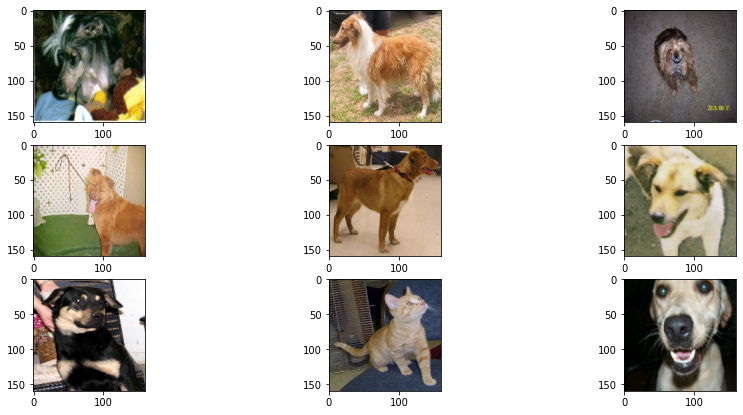

In [87]:
for img,lbl in train_ds.take(1):
  cnt=0
  fig,ax=plt.subplots(3,3,figsize=(15,7))
  for i in range(3):
    for j in range(3):
      ax[i,j].imshow(img[cnt]/255.0)
      cnt+=1
    #plt.imshow(img[i]/255.0)


## With Augumentation

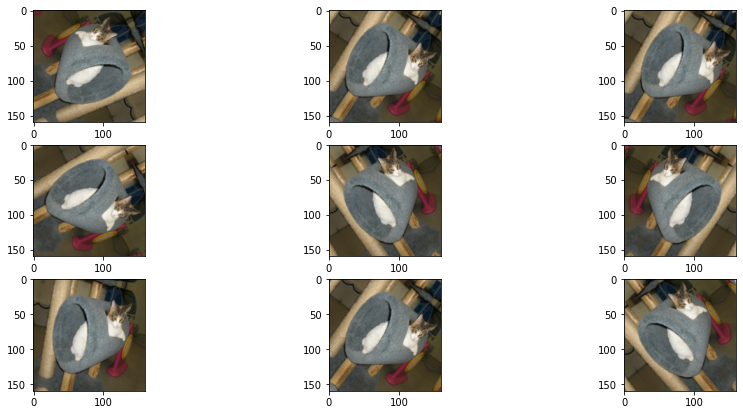

In [88]:
for img,lbl in train_ds.take(1):
  cnt=0
  fig,ax=plt.subplots(3,3,figsize=(15,7))
  first_img=img[0]
  for i in range(3):
    for j in range(3):
      aug_img=data_augument(tf.expand_dims(first_img,axis=0))

      ax[i,j].imshow(aug_img[0]/255.0)
    #plt.imshow(img[i]/255.0)


In [90]:
IMG_SHAPE=IMG_SIZE+(3,)
print(IMG_SHAPE)

base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

(160, 160, 3)


In [91]:
image_batch,lbl_batch=next(iter(train_ds))
print(image_batch.shape)

(32, 160, 160, 3)


In [93]:
feature_extractor=base_model(image_batch)
print(feature_extractor.shape)

(32, 5, 5, 1280)


In [94]:
base_model.trainable=False

In [101]:
inputs=tf.keras.layers.Input(shape=IMG_SHAPE)
l2=data_augument(inputs)
l3=tf.keras.applications.mobilenet_v2.preprocess_input(l2)
l4=base_model(l3,training=False)
l5=tf.keras.layers.GlobalAveragePooling2D()(l4)
outputs=tf.keras.layers.Dense(1)(l5)
model=tf.keras.Model(inputs,outputs)

In [103]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281

In [106]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 4s 65ms/step - loss: 0.6026 - accuracy: 0.6287
initial loss: 0.60
initial accuracy: 0.63


In [107]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds)

Epoch 1/10
63/63 [==============================] - 9s 83ms/step - loss: 0.5352 - accuracy: 0.7110 - val_loss: 0.4093 - val_accuracy: 0.8119
Epoch 2/10
63/63 [==============================] - 4s 72ms/step - loss: 0.4064 - accuracy: 0.8115 - val_loss: 0.3006 - val_accuracy: 0.8738
Epoch 3/10
63/63 [==============================] - 4s 72ms/step - loss: 0.3295 - accuracy: 0.8575 - val_loss: 0.2387 - val_accuracy: 0.9010
Epoch 4/10
63/63 [==============================] - 4s 71ms/step - loss: 0.2919 - accuracy: 0.8740 - val_loss: 0.2007 - val_accuracy: 0.9171
Epoch 5/10
63/63 [==============================] - 4s 72ms/step - loss: 0.2573 - accuracy: 0.8920 - val_loss: 0.1751 - val_accuracy: 0.9319
Epoch 6/10
63/63 [==============================] - 5s 72ms/step - loss: 0.2348 - accuracy: 0.8995 - val_loss: 0.1561 - val_accuracy: 0.9431
Epoch 7/10
63/63 [==============================] - 4s 72ms/step - loss: 0.2185 - accuracy: 0.9035 - val_loss: 0.1414 - val_accuracy: 0.9493
Epoch 8/10
63

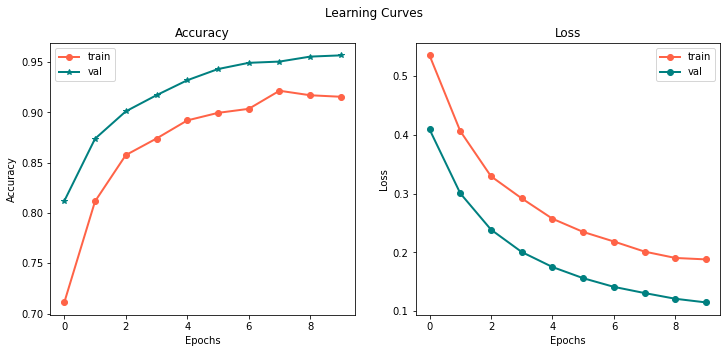

In [108]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,2,figsize=(12,5))
epochs=range(len(history.history['accuracy']))

ax[0].plot(epochs,history.history['accuracy'],label='train',lw=2,marker='o',color='tomato')
ax[0].plot(epochs,history.history['val_accuracy'],label='val',lw=2,marker='*',color='teal')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()


ax[1].plot(epochs,history.history['loss'],label='train',lw=2,marker='o',color='tomato')
ax[1].plot(epochs,history.history['val_loss'],label='val',lw=2,marker='o',color='teal')
ax[1].set_title('Loss')
ax[1].legend()

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
plt.suptitle('Learning Curves')
plt.show()

In [109]:
base_model.trainable = True

In [110]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [112]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [113]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281

In [114]:
len(model.trainable_variables)

56

In [115]:
history.epoch[-1]

9

In [117]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 10/20
63/63 [==============================] - 14s 116ms/step - loss: 0.1458 - accuracy: 0.9375 - val_loss: 0.0553 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 6s 98ms/step - loss: 0.1064 - accuracy: 0.9590 - val_loss: 0.0467 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 6s 99ms/step - loss: 0.0899 - accuracy: 0.9655 - val_loss: 0.0437 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 6s 97ms/step - loss: 0.0790 - accuracy: 0.9680 - val_loss: 0.0376 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 6s 97ms/step - loss: 0.0857 - accuracy: 0.9635 - val_loss: 0.0393 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 6s 98ms/step - loss: 0.0815 - accuracy: 0.9710 - val_loss: 0.0378 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 6s 98ms/step - loss: 0.0705 - accuracy: 0.9700 - val_loss: 0.0361 - val_accuracy: 0.9864
Epoc

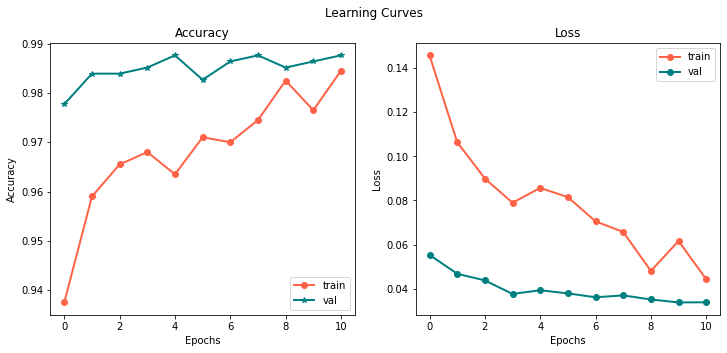

In [118]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,2,figsize=(12,5))
epochs=range(len(history_fine.history['accuracy']))

ax[0].plot(epochs,history_fine.history['accuracy'],label='train',lw=2,marker='o',color='tomato')
ax[0].plot(epochs,history_fine.history['val_accuracy'],label='val',lw=2,marker='*',color='teal')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()


ax[1].plot(epochs,history_fine.history['loss'],label='train',lw=2,marker='o',color='tomato')
ax[1].plot(epochs,history_fine.history['val_loss'],label='val',lw=2,marker='o',color='teal')
ax[1].set_title('Loss')
ax[1].legend()

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
plt.suptitle('Learning Curves')
plt.show()

In [120]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 66ms/step - loss: 0.0522 - accuracy: 0.9792
Test accuracy : 0.9791666865348816
